# 090 Evaluating Classifier Performance

> COM6018

*Copyright &copy; 2024 Jon Barker, University of Sheffield. All rights reserved*.

## 1. Introduction

In the previous classification tutorials, we have been evaluating the performance of classifiers by looking at the accuracy of the predictions. In this tutorial, we will look at more sophisticated ways of evaluating classifier performance. We will introduce the concepts of precision and recall. We will also look at the Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) as a way of evaluating classifier performance. Furthermore, we will also look at how to evaluate classifiers when the data is imbalanced and when there are asymmetric costs associated with different types of errors. Finally, we will look at how to extend the evaluation of classifiers to multiclass problems.

## 2. Analysis of a toy two-class problem

To motivate the discussion that follow, we will generate a toy two-class problem. In these toy data, we will have two-dimensional feature vectors $(x_1, x_2)$ generated from two classes. Samples from each class are generated by a different distribution. For the $x_2$ feature, the classes will be drawn from a Gaussian distribution with different means and equal variances. For the $x_1$ feature, it will be independent of $x_2$, with each class having the same uniform distribution. So, the $x_2$ feature will be more informative. The $x_1$ feature has been added just to make it easier to see the data in a plot, i.e., by spreading out the points in the $x_1$ direction.

The code below will generate the toy data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Set the random seed so that the same data are generated each time
np.random.seed(0)
def generate_data(x2_mean, n_samples):
    x1 = np.random.uniform(0, 1, n_samples)
    x2 = np.random.normal(x2_mean, 1, n_samples)
    return np.column_stack((x1, x2))

In [2]:
n_class1 = n_class2 = 200
class1 = generate_data(-1, n_class1)
class2 = generate_data(1, n_class2)
data = np.vstack((class1, class2))
labels = np.hstack((np.zeros(n_class1), np.ones(n_class2)))

We can now plot the data. We will see that the two classes fully overlap in the $x_1$ feature, but are partially separable in the $x_2$ feature.

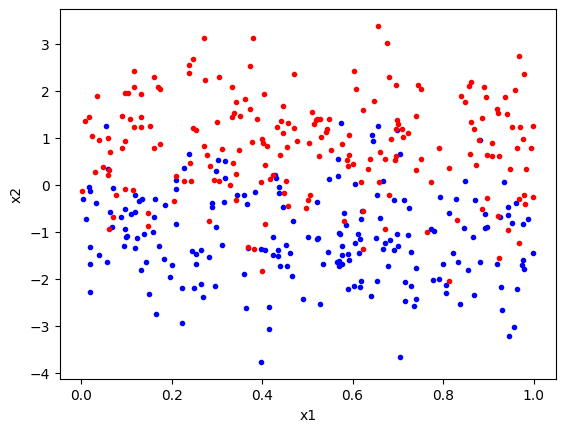

In [3]:
import matplotlib.pyplot as plt
plt.plot(class1[:, 0], class1[:, 1], 'b.')
plt.plot(class2[:, 0], class2[:, 1], 'r.')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Given that we know the underlying distributions of the data, we can generate a classifier that will perform well on these data. The $x_2$ Gaussians have the same variance, so the Bayes optimal classifier will be a linear classifier with a decision boundary at $x_2 = 0$, for all values of $x_1$, i.e., to classify a point, we just need to look at the $x_2$ value and assign class 1 if it is negative and class 2 if it is positive.

In the code below, we define a simple classifier that implements this decision boundary and evaluates its performance on the toy data.

In [4]:
def classify(x, threshold=0):
    return x[:, 1] > threshold

In [5]:
def evaluate(predictions, labels):
    accuracy = np.sum(predictions == labels) / len(labels) * 100
    return accuracy

In [6]:
predictions = classify(data)
accuracy = evaluate(predictions, labels)
print(f'Accuracy: {accuracy} percent')

Accuracy: 84.25 percent


The classifier accuracy is about 84%.

We can verify that placing the decision boundary at $x_2 = 0$ is the optimal decision boundary by plotting the classification accuracy as a function of the decision boundary position.

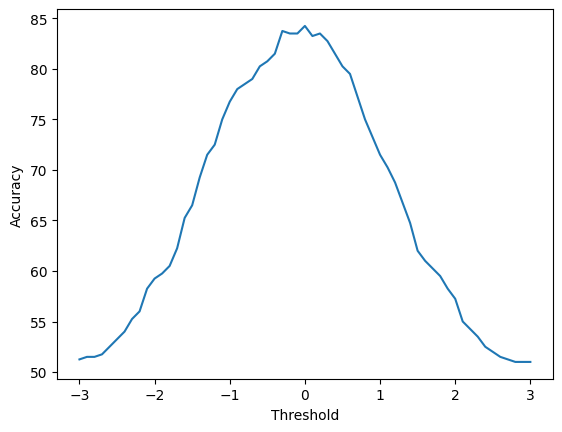

In [7]:
thresholds = np.linspace(-3, 3, 61)
predictions = [classify(data, threshold) for threshold in thresholds]
accuracies = [evaluate(prediction, labels) for prediction in predictions]
plt.plot(thresholds, accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

You will note that the best performance does indeed occur close to when the decision boundary is at $x_2 = 0$. The curve is not completely smooth, and there might be threshold values close to 0 that give slightly better performances on the data. This is because we have a finite sample of data. If you rerun with a large sample size, then the curve will be smoother.

So far, this is all very simple. We have a classifier with two classes, and we imagine that for our use case, we care about making as few classification errors as possible. Having the smallest number of errors is the same as getting the most number of decisions correct, i.e. the accuracy metric is all we need to consider when evaluating the classifier. This might be suitable, for example, if designing a system that takes a photo and labels is at 'indoors' versus 'outdoors'

However, in many cases, we are interested in more than just the accuracy of the classifier. These cases occur when we start considering that the consequence of making different types of classification error may be very different. The rest of this tutorial will consider these more complex cases.

## 3. Detection as a binary classification problem

In this section, we will consider a family of classification problems where the classification error type is typically very important: detection problems. In detection problems, we are trying to detect the presence of some phenomenon. The phenomenon could be the presence of a disease in a patient, the presence of a target in a radar image, the presence of a fault in a machine, etc. This can be seen as a binary classification problem where one class is the phenomenon is 'present' and the other class is the phenomenon is 'absent'.

To motivate the discussion, we will consider an example scenario. Consider the case of taking a lateral flow test for Covid-19. The test works by measuring the presence of a protein associated with the virus. The protein level is measured in a continuous scale and the test has a threshold value. If the protein level is above the threshold, the test is positive, and if it is below the threshold, the test is negative.

Let us use the same data that we generated in the previous example, but now imagine that each point represents a Covid-19 test and the x2 variable is the protein level. We are using this test to detect Covid-19. That is, we are trying to separate the positive tests (red), i.e. presence of the virus, from the negative tests (blue), i.e. absence of the virus.

If our test is good, then the accuracy will be high, that is, it will report Covid-19 when the person has Covid-19, and it will report no Covid-19 when the person does not have Covid-19. However, we can now see that this is not the only consideration because there are two very different types of error that can be made. The test can report no Covid-19 when the person has Covid-19 (false negative) or it can report Covid-19 when the person does not have Covid-19 (false positive). Each of these errors has a different consequence. Imagine that our population taking the test was medical staff working in an intensive care unit. A false positive would mean that the staff member would be sent home from work, at least until they could take a more sensitive test to check the result. A false negative would mean that the staff member would continue to work and potentially infect patients and other staff members. The consequences of a false negative are much more severe than the consequences of a false positive.

So, if the error types have different consequences, then we need to consider more than just the accuracy of the classifier. We want to be able to measure the false positive rate and the false negative rate. These are defined as follows:

- False Positive Rate (FPR) = FP / (FP + TN)
- False Negative Rate (FNR) = FN / (FN + TP)

where FP is the number of false positives, TN is the number of true negatives, FN is the number of false negatives, and TP is the number of true positives.

Let us now return to our toy data and evaluate the classifier in terms of both the accuracy and the false positive rate and the false negative rate. We will plot these values as functions of the decision boundary threshold as before.

In [8]:
def false_positive_rate(predictions, labels):
    return np.sum(np.logical_and(predictions, np.logical_not(labels))) / np.sum(np.logical_not(labels))

def false_negative_rate(predictions, labels):
    return np.sum(np.logical_and(np.logical_not(predictions), labels)) / np.sum(labels)

In [9]:
thresholds = np.linspace(-3, 3, 61)
predictions = [classify(data, threshold) for threshold in thresholds]
accuracies = [evaluate(prediction, labels) for prediction in predictions]
fpr = np.array([false_positive_rate(prediction, labels) for prediction in predictions])
fnr = np.array([false_negative_rate(prediction, labels) for prediction in predictions])

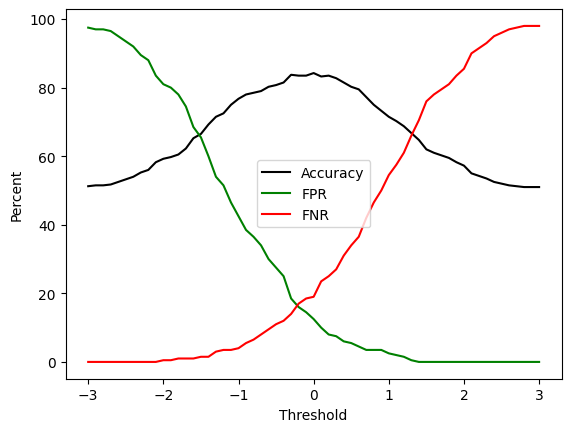

In [10]:
plt.plot(thresholds, accuracies, 'k', label='Accuracy')
plt.plot(thresholds, fpr * 100, 'g', label='FPR')
plt.plot(thresholds, fnr * 100, 'r', label='FNR')
plt.xlabel('Threshold')
plt.ylabel('Percent')
plt.legend()
plt.show()

We can see from this plot that although the FPR and FNR are both low at the threshold value of 0, we can further reduce the false positives by increasing the detection threshold, or we can reduce the false negatives by decreasing the detection threshold. This is a trade-off. If, as we argued before, the consequences of false negatives are more severe than the consequences of false positives, then we might want to set the threshold to a lower value to reduce the false negatives. For example, setting the threshold to -2 would increase the number of false positives, and would increase the number of errors overall, but it would reduce the number of false negatives to close to zero.

## 4. Receiver Operator Curve (ROC) analysis

When plotting the FPR and FNR, it is more typical not to plot the threshold value on the x-axis, but to plot the FPR and FNR directly against each other. This is because the threshold value is not a very meaningful value to plot. The FPR and FNR are more meaningful because they are the error rates that we are interested in.

The convention, known as a receiver operator curve (ROC) is to plot the FPR on the x-axes and $1 - FNR$ on the y-axis. Note that $1-FNR$ is equal to the True Positive Rate (TPR), which is also known as the 'sensitivity'.

So, in summary, for the ROC curve, the x-axis, is the False Positive Rate (FPR)

- FPR = FP / (FP + TN)

The y-axis is the True Positive Rate (TPR), also known as the Sensitivity,

- TPR = 1 - FNR = TP / (TP + FN)

We can plot the ROC curve for our toy data as follows:

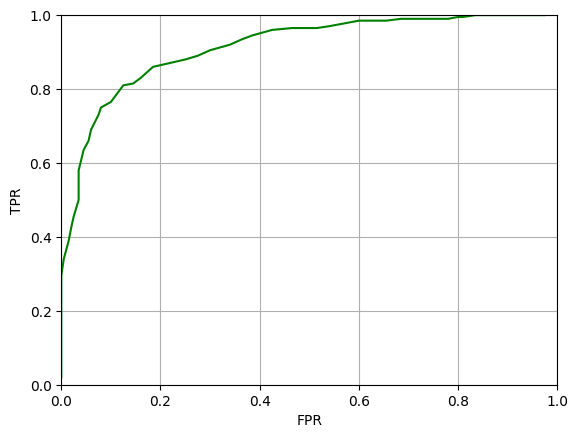

In [11]:
tpr = 1 - fnr
plt.plot(fpr, tpr, 'g')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()
plt.show()

The ROC curve is a useful way to visualise the performance of a classifier. The ideal classifier would have a TPR of 1 and an FPR of 0, that is, it would be in the top left corner of the plot. A classifier that is no better than random guessing would have a ROC curve that is a straight line from the bottom left to the top right. The area under the ROC curve (AUC) is a measure of the performance of the classifier. The AUC is a value between 0 and 1. A classifier with an AUC of 1 is a perfect classifier, a classifier with an AUC of 0.5 is no better than random guessing.

We can estimate the AUC for our classifier as follows:

In [12]:
def auc(fpr, tpr):
    sorted_indices = np.argsort(fpr)
    fpr = np.array(fpr)[sorted_indices]
    tpr = np.array(tpr)[sorted_indices]
    return np.trapezoid(tpr, fpr)

In [13]:
auc_value = auc(fpr, 1-fnr)
print(f'AUC: {auc_value}')

AUC: 0.8882875


## 5. Imbalanced data sets

In many detection problems, the data are imbalanced. That is, one class is much more common than the other. For example, in the Covid-19 test example, the number of people without Covid-19 is much larger than the number of people with Covid-19. In the toy data that we have been using, the number of samples in each class was the same. Let us now make a new data set where the number of samples in each class is different.

In the following we use the same data generating functions as before, but we do not make the number of samples in the two classes very different. We will have 4000 samples in class 1 (absent) and 40 samples in class 2 (present).

In [14]:
n_class1 = 4000
n_class2 = 40
class1_imbalanced = generate_data(-1, n_class1)
class2_imbalanced = generate_data(1, n_class2)
data_imbalanced = np.vstack((class1_imbalanced, class2_imbalanced))
labels_imbalanced = np.hstack((np.zeros(n_class1), np.ones(n_class2)))

We plot this below and it is clear that there are many more blue points than red points.

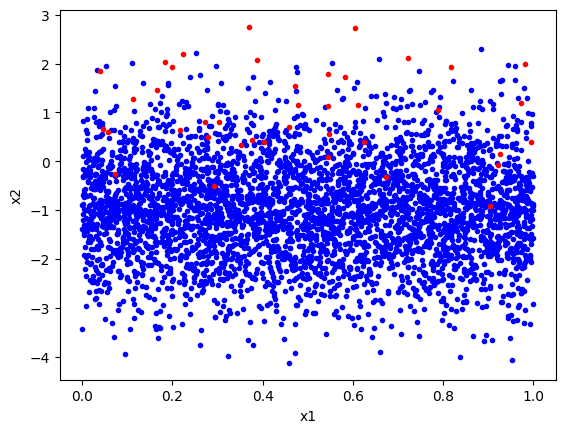

In [15]:
plt.plot(class1_imbalanced[:, 0], class1_imbalanced[:, 1], 'b.')
plt.plot(class2_imbalanced[:, 0], class2_imbalanced[:, 1], 'r.')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Likewise, we can follow the same steps as before in order to compute the classifier's accuracy. Then we calculate the FPR and FNR for a range of detection thresholds so that we can plot the ROC curve and measure the AUC.

In [16]:
predictions = classify(data_imbalanced, threshold=0)
accuracy = evaluate(predictions, labels_imbalanced)
print(f'Accuracy: {accuracy} percent')

Accuracy: 84.57920792079207 percent


The accuracy is again about 84% and the ROC curve looks similar to before.

In [17]:
thresholds = np.linspace(-3, 3, 61)
predictions = [classify(data_imbalanced, threshold) for threshold in thresholds]
accuracies = [evaluate(prediction, labels_imbalanced) for prediction in predictions]
fpr = np.array([false_positive_rate(prediction, labels_imbalanced) for prediction in predictions])
fnr = np.array([false_negative_rate(prediction, labels_imbalanced) for prediction in predictions])

We can again compute the AUC value, and it will be similar to before.

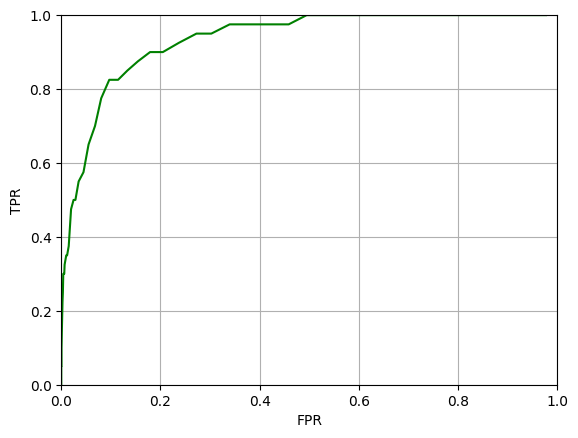

In [18]:
tpr = 1 - fnr
plt.plot(fpr, tpr, 'g')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()
plt.show()

In [19]:
auc_value = auc(fpr, 1-fnr)
print(f'AUC: {auc_value}')

AUC: 0.911696875


All looks fine, and the high AUC value might lead us to believe that we have a useable classifier. However, the accuracy and AUC are misleading in this case.

Consider the accuracy: At the threshold of 0 the accuracy is 84.5%, but the accuracy could be made far, far higher by just classifying everything as Class 1. That is, if we were to set the threshold so high that Covid was never detected, we would be correct 4000 times and wrong just 40 and our accuracy would be 4000/(4000+40) = 99%. So, we could have a Covid test that never detects Covid (and is hence entirely useless), but could still be reported to have an accuracy of 99%!

The ROC curve and AUC are also somewhat misleading.  The AUC is high because the False Positive Rate is low for a given True Positive Rate. However, note that the denominator of the FPR is the number of true negatives. In this case, the number of true negatives is very high because the data is imbalanced. So, even though the FPR rate is very low, there may still be a very large number of false positives. There could be dozens of false positives for every Covid case detected. This might be acceptable, but it is not something that is captured by the AUC.

In cases where the data are heavily imbalanced, it is better to use the Precision-Recall curve and the Area Under the Precision-Recall curve (AUC-PR) as a measure of classifier performance. The Precision-Recall curve plots the Precision (on the y-axis) against the Recall (on the x-axis). Precision and Recall are defined as:

- Precision = TP / (TP + FP)
- Recall = TP / (TP + FN)

That is, in our case, precision is the fraction of positive Covid tests that were real cases of Covid, whereas Recall is the fraction of the real cases of Covid that were detected by the test.

These two are often summarised by the F1 score, which is the harmonic mean of the two:

- F1 = 2 *Precision* Recall / (Precision + Recall)

We can plot the Precision-Recall curve for our imbalanced data as follows:

In [20]:
def precision(predictions, labels):
    positive_predictions = np.sum(predictions)
    if positive_predictions == 0:  # Note this special case
        return 0
    return np.sum(np.logical_and(predictions, labels)) /  positive_predictions

def recall(predictions, labels):
    positive_labels = np.sum(labels)
    if positive_labels == 0:  # Note this special case
        return 0
    return np.sum(np.logical_and(predictions, labels)) / positive_labels

In [21]:
precisions = np.array([precision(prediction, labels_imbalanced) for prediction in predictions])
recalls = np.array([recall(prediction, labels_imbalanced) for prediction in predictions])

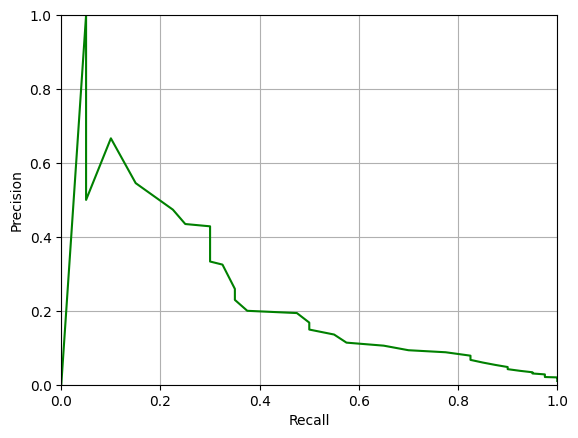

In [22]:
plt.plot(recalls, precisions, 'g')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()
plt.show()

Note that, ideally, we would like there to be some threshold where both Precision and Recall are close to 1.0, i.e. for a good system the PR-curve should pass close to the top-right corner of the plot. You can see from the plot above that this is far from the case for our classifier.

We can compute the AUC-PR value as follows:

In [23]:
def auc_pr(precisions, recalls):
    sorted_indices = np.argsort(recalls)
    precisions = np.array(precisions)[sorted_indices]
    recalls = np.array(recalls)[sorted_indices]
    return np.trapezoid(precisions, recalls)

auc_pr_value = auc_pr(precisions, recalls)
print(f'AUC-PR: {auc_pr_value}')

AUC-PR: 0.24244631785175957


The AUC-PR value is much lower than the AUC value -- about 0.24 versus 0.91. This is a more accurate reflection of the performance of the classifier on the imbalanced data.

## 7. Extending to multiclass problems

In all of the above, we have been considering binary classification problems (such as detection problems) and defining one class to be the positive class and the other class to be the negative class. However, in many cases, we have multiclass classification problems with more than two classes. How can we extend the concepts of Precision, Recall, FPR, FNR, ROC, AUC, and PR to multiclass problems.

For multiclass problems, the standard approach is to use the 'one-vs-all' approach. That is, we consider each class in turn as the positive class and all the other classes as the negative class. So, for example, if we have a four class problem ('cat', 'dog', 'bird', 'fish'), we treat it as it were four separate binary classification problem ('cat' vs 'not cat'; 'dog' vs 'not dog'; 'bird' vs 'not bird'; 'fish' vs 'not fish').  We can then compute the Precision, Recall, FPR, FNR, ROC, AUC, and PR for each class. We can then average these values over all classes.

There are two common ways of averaging these values, called micro-averaging and macro-averaging. They both involve computing the values for each class and averaging, but the difference is that in micro-averaging, each class is given equal weight, whereas in macro-averaging each class is given equal weight.  So for balanced data sets, the two methods will give the same result, but for imbalanced data sets, the two approaches will give different results, and micro-averaging is generally preferred.

## 8. Evaluating classifiers in Scikit-learn

In [24]:
# Generate separate training and test data
# Using the same distributions as in our toy example.

n_class1 = n_class2 = 200
class1 = generate_data(-1, n_class1)
class2 = generate_data(1, n_class2)
data_train = np.vstack((class1, class2))
labels_train = np.hstack((np.zeros(n_class1), np.ones(n_class2)))

class1 = generate_data(-1, n_class1)
class2 = generate_data(1, n_class2)
data_test = np.vstack((class1, class2))
labels_test = np.hstack((np.zeros(n_class1), np.ones(n_class2)))

Here we will use the Scikit-learn library to build a logistic regression classifier. This is a simple linear classifier that is suitable for binary classification problems.

We will train the classifier on the training data and then evaluate it on the test data.

In [25]:
from sklearn.linear_model import LogisticRegression

# Build and train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(data_train, labels_train)

LogisticRegression()

We can now evaluate the classifier on the test data using the `classifier.predict` method.  Then by using the predicted labels and the test data labels we can compute the accuracy, precision and recall by using the functions `accuracy_score`, `precision_score` and `recall_score` from the `sklearn.metrics` module.

In [26]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
# Get predictions on the test data
predictions = classifier.predict(data_test)

# Compute the precision, recall, and accuracy
precision = precision_score(labels_test, predictions)
recall = recall_score(labels_test, predictions)
f1 = f1_score(labels_test, predictions)
accuracy = accuracy_score(labels_test, predictions)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')
print(f'Accuracy: {accuracy}')

Precision: 0.8368421052631579
Recall: 0.795
F1: 0.8153846153846154
Accuracy: 0.82


To compute the ROC curve in the previous examples, we changed the detection threshold. This is equivalent to changing the decision threshold in the classifier. In Scikit-learn, we do things a little differently. For a fixed position of the decision boundary, we use the `classifier.predict_proba` method to get the probability that each sample belongs to positive class. i.e., the classifier is now producing a probability between 0 and 1 for each sample, rather than a class label of 0 or 1. We can then effectively very the decision threshold by changing the probability threshold at which we decide to classify a sample as positive or negative.

To make it clearer how thresholding the probability estimate acts as moving the decision boundary, we can plot a contour plot where the probability levels are shown in the feature space. The code below does this.

/var/folders/ps/hyszp8bj4g9269mcf_y3psz40000gp/T/ipykernel_40394/2886000782.py:8: UserWarning: The following kwargs were not used by contour: 'label'
  contour=plt.contour(X1, X2, probs, levels=np.arange(0,1,0.1), colors='k', label='Decision Boundary')


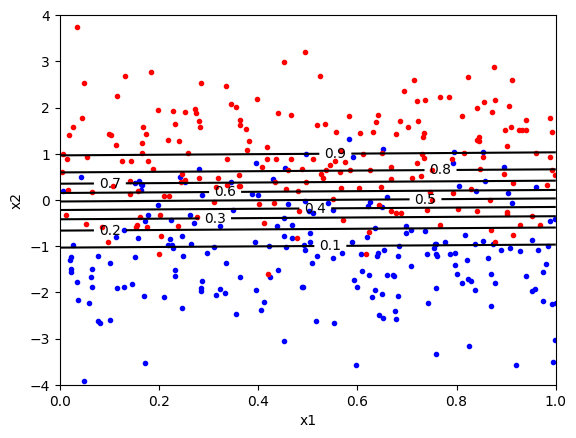

In [27]:
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(-4, 4, 100)
X1, X2 = np.meshgrid(x1, x2)
X = np.column_stack((X1.ravel(), X2.ravel()))
probs = classifier.predict_proba(X)[:, 1].reshape(X1.shape)
plt.plot(class1[:, 0], class1[:, 1], 'b.')
plt.plot(class2[:, 0], class2[:, 1], 'r.')
contour=plt.contour(X1, X2, probs, levels=np.arange(0,1,0.1), colors='k', label='Decision Boundary')
plt.clabel(contour, inline=True, fontsize=10)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In the above plot, the contour at $p=0.5$ is the decision boundary. The classifier will classify a sample as positive (red) if the probability is greater than 0.5 and negative (blue) if the probability is less than 0.5. We can change the threshold by changing the probability threshold. For example, if we want to reduce the number of false positives, we can increase the threshold to 0.9. There would now be very few false positive (i.e., blue points above the boundary), but many false negatives (i.e., red points below the boundary).

So the ROC curve can be computed by counting the number of true positives and false positives for a range of probability thresholds. The code for computing the ROC curve and the AUC is below. The `classifier.predict_proba()` method computes the probability. The `roc_curve` function computes the FPR and TPR for a range of probability thresholds, i.e. the `fpr` and `tpr` variables below store a complete list of values that represent the complete ROC curve. The `roc_auc_score` function computes the AUC value.

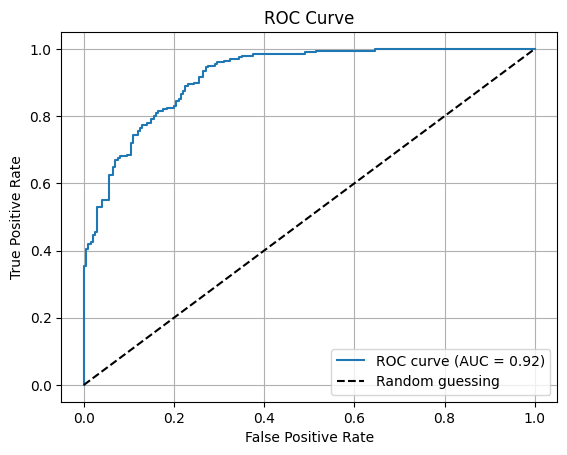

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve

# Retrieve the probability predictions for the positive class
probability_predictions = classifier.predict_proba(data_test)[:, 1]

# Compute the ROC curve and AUC
fpr, tpr, _ = roc_curve(labels_test, probability_predictions)
roc_auc = roc_auc_score(labels_test, probability_predictions)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guessing')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

Note that we can compute the ROC curve for any classifier in sklearn that provides a `predict_proba` method. Not all classifiers do, but many do.

Below we compute the Precision-Recall curve and the AUC-PR, which sklearn calls the average precision. The approach is the same as for the ROC curve except that we use the `precision_recall_curve` function to compute the precision and recall for a range of probability thresholds.

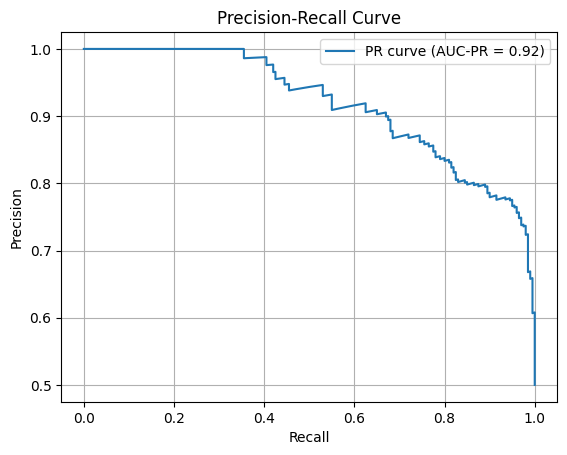

In [29]:
from sklearn.metrics import precision_recall_curve, average_precision_score

probability_predictions = classifier.predict_proba(data_test)[:, 1]
precision, recall, _ = precision_recall_curve(labels_test, probability_predictions)
average_precision = average_precision_score(labels_test, probability_predictions)

plt.plot(recall, precision, label=f'PR curve (AUC-PR = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

As an exercise, return to the data generation functions and make a training and test data set with a large class imbalance and then replot the ROC and PR curves. You should see that the AUC-PR will become lower than the AUC.

## 9. Summary

This tutorial has introduced a number of more advanced concepts for evaluating classifier performance. The key points are the following.

- Evaluation Beyond Accuracy: This tutorial extends classifier evaluation beyond accuracy by introducing precision, recall, ROC curves, and AUC as key metrics. It also explores how to handle imbalanced datasets and asymmetric error costs, emphasising scenarios where different types of classification errors carry unequal consequences.
- Toy Example Analysis: A two-class toy problem demonstrates how feature distributions influence classifier performance. The Bayes optimal decision boundary is identified, and the trade-offs between false positive and false negative rates are examined as a function of decision thresholds.
- Imbalanced Data and PR Curves: The limitations of accuracy and ROC/AUC metrics in imbalanced datasets are highlighted, with a focus on Precision-Recall (PR) curves and the Area Under the PR curve (AUC-PR) as better alternatives. The tutorial shows how AUC-PR reflects performance more accurately in skewed datasets.
- MultiClass and Practical Implementation: Concepts like one-vs-all classification, micro- and macro-averaging are introduced to extend binary evaluation metrics to multiclass problems. Practical implementation in Scikit-learn is mentioned for applying these evaluation techniques.